In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import matplotlib.pyplot as plt
from src.Simulator.SSA import SSASimulator
import numpy as np
from src.Estimation.FullObsNN import IndividualReactionsNN
from src.Estimation.FullObsNN import DataPreparatorFullObs
from src.Models.utils import getReactionsForObservations
from src.Estimation.utils import createPropensityPlot
from src.Estimation.MLE import MLEstimator

# NN for Birth Death Model
First, we build the dynamic model to create the training data

In [24]:
from src.Models.example_networks import BirthDeath
model_bd = BirthDeath()
simulator_bd = SSASimulator(model_bd)

parameters = model_bd.getDefaultParameter()
x0 = model_bd.getDefaultInitialState()

We set up the NN model

In [25]:
data_preparator = DataPreparatorFullObs()
num_trajs = 100
for num_traj in range(num_trajs):
    y, t = simulator_bd.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_bd.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)
    
num_states = y.shape[1]
num_unique_stoch = len(np.unique(unique_reaction_mapping))
species_by_reaction = model_bd.getSpeciecByReaction()

custom_model = IndividualReactionsNN(num_outputs=num_unique_stoch, num_layers=2, num_neurons=8, learning_rate=0.001, inputs_by_output = species_by_reaction)
train_dataset = data_preparator.getTraindDataset()

We train the model on the training data

In [14]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
75/75 [==============================] - 2s 3ms/step - loss: 69707.5234
Epoch 2/200
75/75 [==============================] - 0s 3ms/step - loss: 65991.6562
Epoch 3/200
75/75 [==============================] - 0s 3ms/step - loss: 65692.0703
Epoch 4/200
75/75 [==============================] - 0s 3ms/step - loss: 65520.7734
Epoch 5/200
75/75 [==============================] - 0s 3ms/step - loss: 65384.5586
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 65287.4453
Epoch 7/200
75/75 [==============================] - 0s 3ms/step - loss: 65223.8203
Epoch 8/200
75/75 [==============================] - 0s 3ms/step - loss: 65184.2812
Epoch 9/200
75/75 [==============================] - 0s 3ms/step - loss: 65160.5000
Epoch 10/200
75/75 [==============================] - 0s 3ms/step - loss: 65144.8203
Epoch 11/200
75/75 [==============================] - 0s 3ms/step - loss: 65131.1328
Epoch 12/200
75/75 [==============================] - 0s 3ms/step - loss: 

We plot the estimation results

7/7 [==============================] - 0s 2ms/step


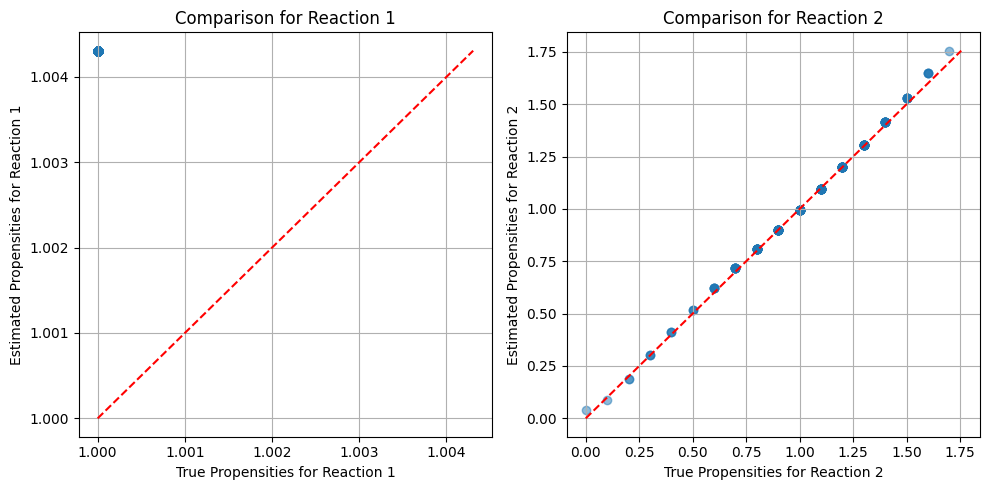

In [15]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_bd.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)
plt.savefig("bd_comparison.svg")

Lets compare it with the MLE 

In [ ]:
estimator = MLEstimator(model_bd, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()
plt.savefig("bd_comparison_MLE.svg")

# NN for Lotka-Voltera Model

In [4]:
from src.Models.paper_examples import ThreeSpeciesModel
model_lv = ThreeSpeciesModel()
simulator_lv = SSASimulator(model_lv)

parameters = model_lv.getDefaultParameter()
x0 = model_lv.getDefaultInitialState()

In [13]:

data_preparator = DataPreparatorFullObs()

num_trajs = 5
for num_traj in range(num_trajs):
    y, t = simulator_lv.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lv.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)

num_states = y.shape[1]
num_unique_stoch = len(np.unique(unique_reaction_mapping))
species_by_reaction = model_lv.getSpeciecByReaction()
custom_model = IndividualReactionsNN(num_outputs=num_unique_stoch, inputs_by_output=species_by_reaction,  num_layers=2, num_neurons=64, learning_rate=0.01)
train_dataset = data_preparator.getTraindDataset()

In [14]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
83/83 [==============================] - 5s 5ms/step - loss: 3871875.7500
Epoch 2/200
83/83 [==============================] - 0s 5ms/step - loss: -59448.7773
Epoch 3/200
83/83 [==============================] - 0s 5ms/step - loss: -59853.0430
Epoch 4/200
83/83 [==============================] - 0s 5ms/step - loss: -59978.5117
Epoch 5/200
83/83 [==============================] - 0s 5ms/step - loss: -60021.2461
Epoch 6/200
83/83 [==============================] - 0s 6ms/step - loss: -60042.6133
Epoch 7/200
83/83 [==============================] - 0s 5ms/step - loss: -60058.9453
Epoch 8/200
83/83 [==============================] - 0s 5ms/step - loss: -60060.6211
Epoch 9/200
83/83 [==============================] - 0s 6ms/step - loss: -60077.6875
Epoch 10/200
83/83 [==============================] - 0s 6ms/step - loss: -60074.6445
Epoch 11/200
83/83 [==============================] - 0s 5ms/step - loss: -60086.0078
Epoch 12/200
83/83 [==============================] - 0s 5ms/s

135/135 [==============================] - 1s 2ms/step


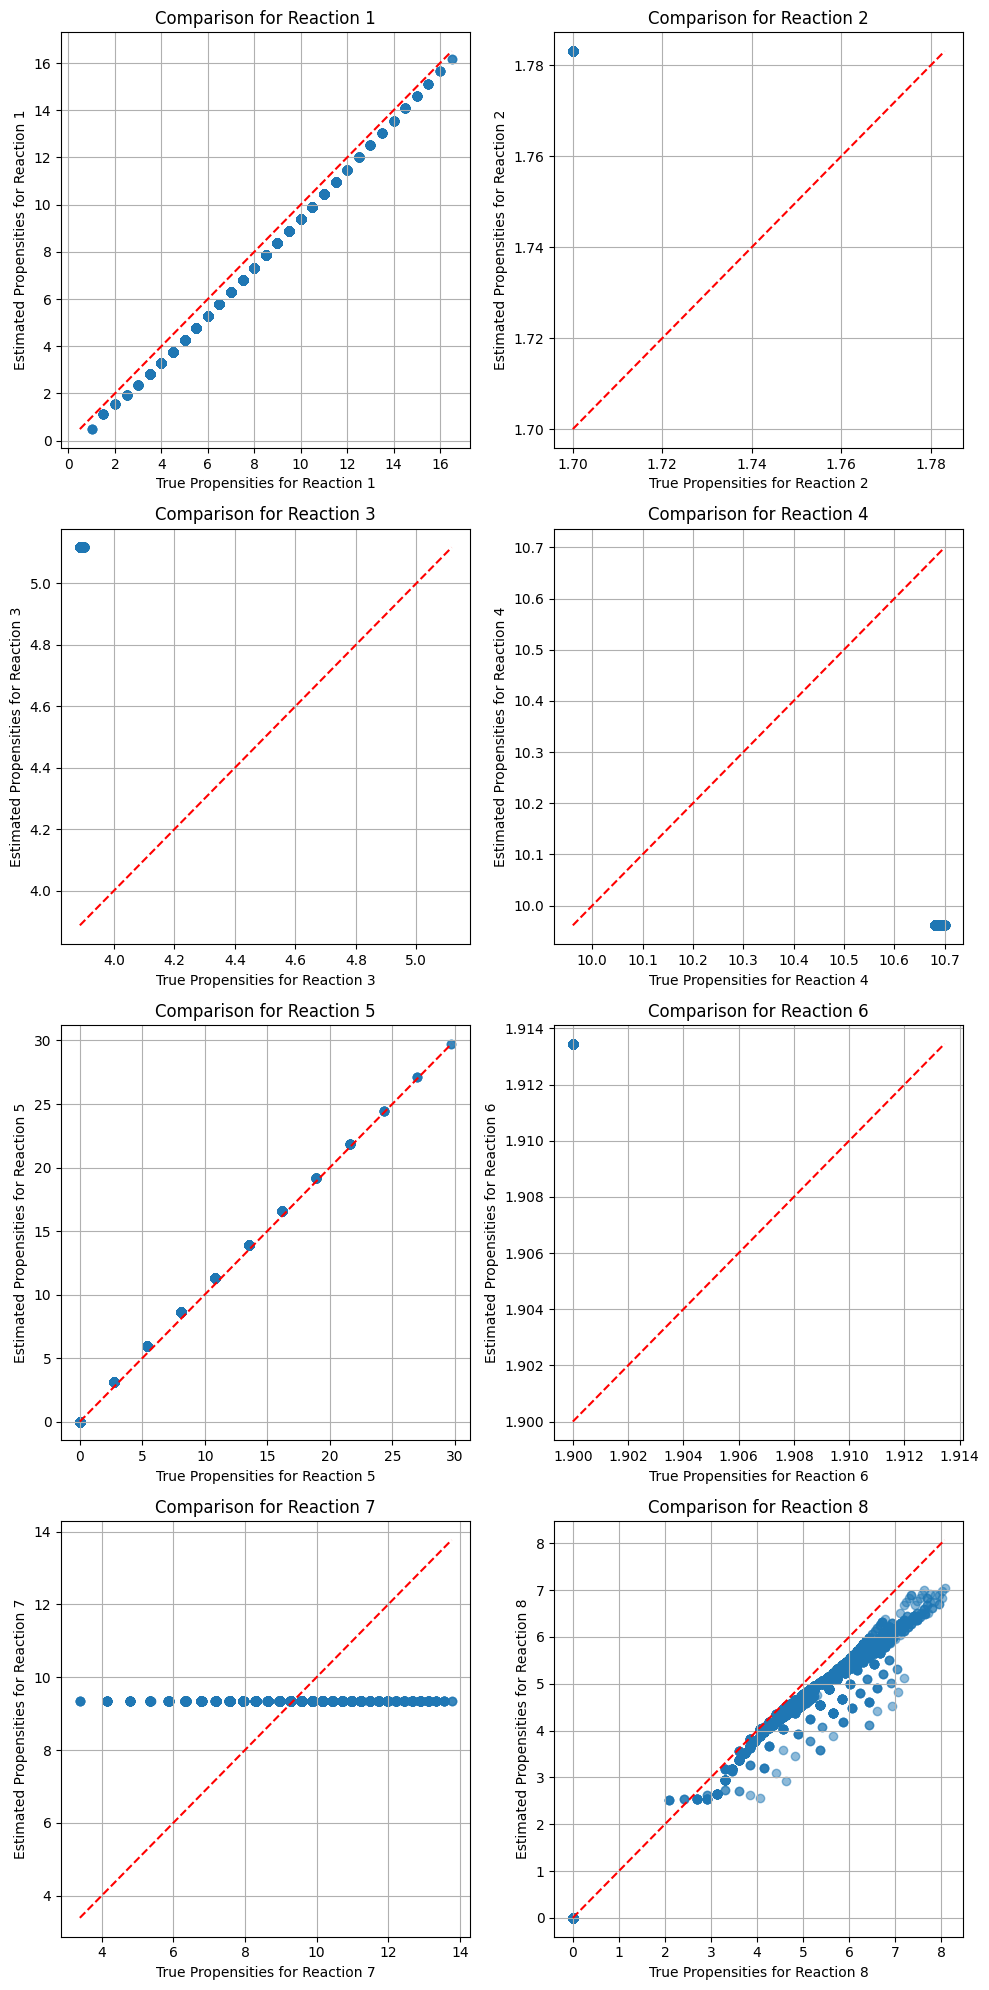

In [15]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lv.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]
fig = createPropensityPlot(nn_predictions, true_props_unique)

# NN for Chemical Reaction Network Model


In [26]:
from src.Models.paper_examples import ChemicalReactionNetwork
model_crn = ChemicalReactionNetwork()
simulator_crn = SSASimulator(model_crn)

parameters = model_crn.getDefaultParameter()
x0 = model_crn.getDefaultInitialState()

In [30]:
data_preparator = DataPreparatorFullObs(batch_size=512)

num_trajs = 10
for num_traj in range(num_trajs):
    y, t = simulator_crn.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_crn.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)

num_states = y.shape[1]
num_unique_stoch = len(np.unique(unique_reaction_mapping))
species_by_reaction = model_crn.getSpeciecByReaction()

custom_model = IndividualReactionsNN(num_outputs=num_unique_stoch, num_layers=2, num_neurons=128, inputs_by_output=species_by_reaction, learning_rate=0.01)
train_dataset = data_preparator.getTraindDataset()

In [31]:
custom_model.fit(train_dataset, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 684206.1250
Epoch 2/1000
1/1 [==============================] - 0s 11ms/step - loss: 501001.5625
Epoch 3/1000
1/1 [==============================] - 0s 12ms/step - loss: 564576.1875
Epoch 4/1000
1/1 [==============================] - 0s 13ms/step - loss: 517896.7188
Epoch 5/1000
1/1 [==============================] - 0s 12ms/step - loss: 464195.8438
Epoch 6/1000
1/1 [==============================] - 0s 12ms/step - loss: 416090.1250
Epoch 7/1000
1/1 [==============================] - 0s 11ms/step - loss: 373170.9375
Epoch 8/1000
1/1 [==============================] - 0s 11ms/step - loss: 361294.9688
Epoch 9/1000
1/1 [==============================] - 0s 12ms/step - loss: 343063.5625
Epoch 10/1000
1/1 [==============================] - 0s 11ms/step - loss: 323149.0938
Epoch 11/1000
1/1 [==============================] - 0s 12ms/step - loss: 313667.3438
Epoch 12/1000
1/1 [==============================] - 0s 10ms/step

1/1 [==============================] - 0s 242ms/step


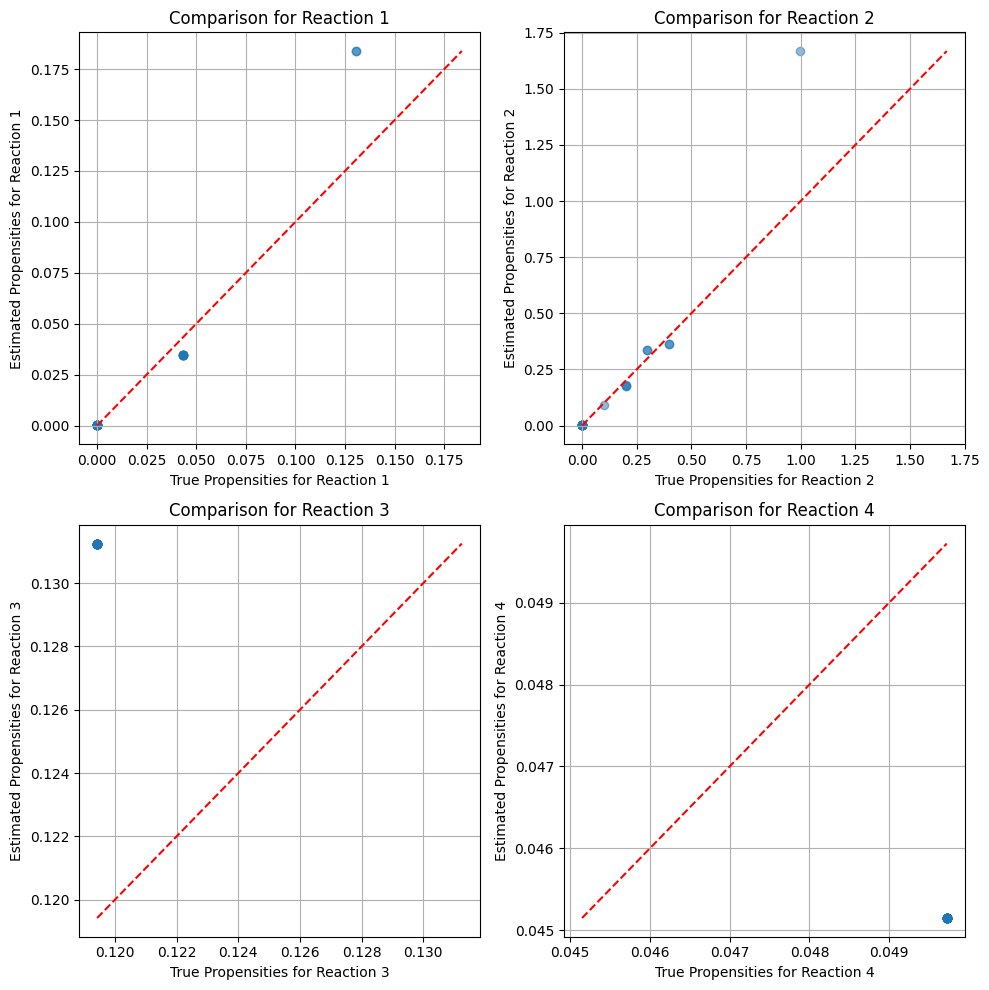

In [32]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_crn.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)

Compare with MLE

/tmp/ipykernel_143788/13457184.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


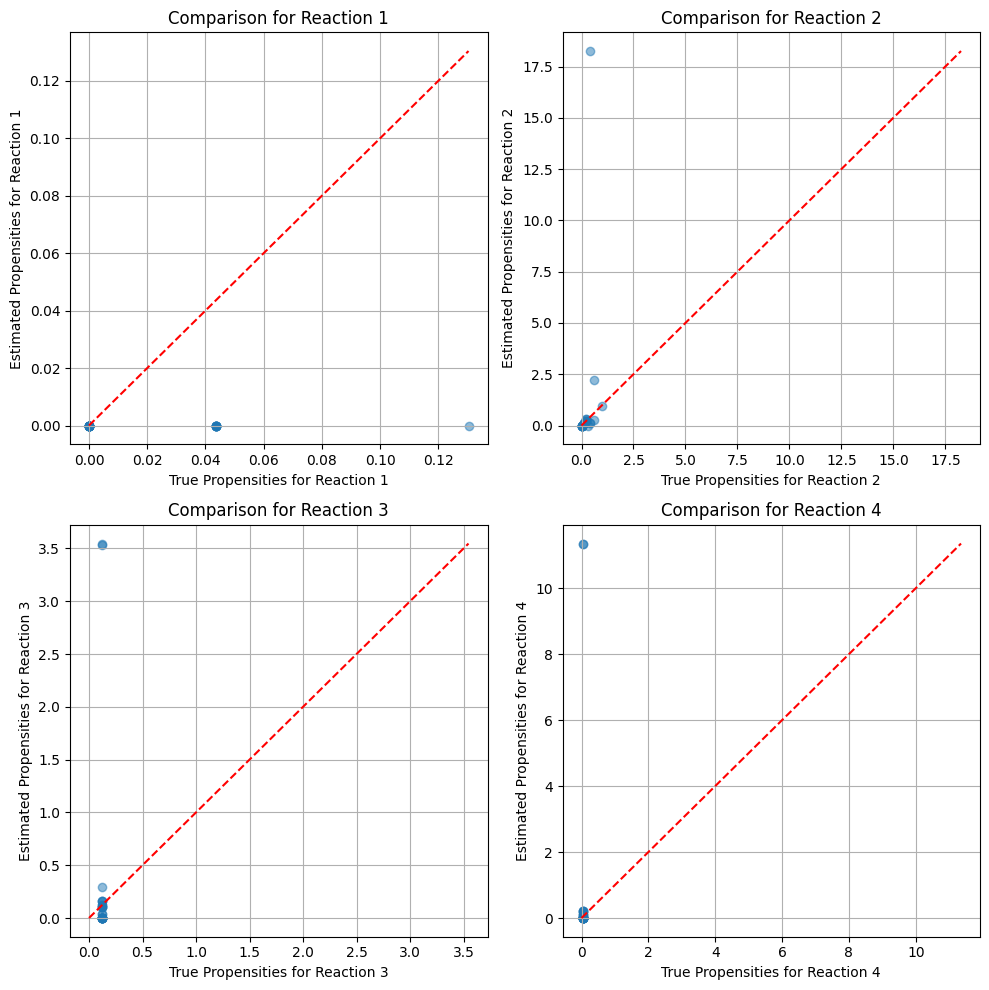

In [11]:
estimator = MLEstimator(model_crn, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()

# Lac-Gfp Model


In [35]:
from src.Models.example_networks import LacGfp
model_lac = LacGfp()
simulator_lac = SSASimulator(model_lac)

parameters = model_lac.getDefaultParameter()
x0 = model_lac.getDefaultInitialState()
y, t = simulator_lac.run_ssa(x0, 10, parameters)

In [41]:

data_preparator = DataPreparatorFullObs()
num_trajs = 5
for num_traj in range(num_trajs -1):
    y, t = simulator_lac.run_ssa(x0, 10, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lac.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)

num_states = y.shape[1]
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lac.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))
species_by_reaction = model_lac.getSpeciecByReaction()

train_dataset = data_preparator.getTraindDataset()

In [42]:
custom_model = IndividualReactionsNN(num_outputs=num_unique_stoch, num_layers=2,num_neurons=64, inputs_by_output=species_by_reaction)

In [45]:
custom_model.fit(train_dataset, epochs=100)

Epoch 1/100
112/112 [==============================] - 1s 7ms/step - loss: -376721.9062
Epoch 2/100
112/112 [==============================] - 1s 8ms/step - loss: -376996.6562
Epoch 3/100
112/112 [==============================] - 1s 8ms/step - loss: -377166.0312
Epoch 4/100
112/112 [==============================] - 1s 8ms/step - loss: -377288.8438
Epoch 5/100
112/112 [==============================] - 1s 9ms/step - loss: -377382.6875
Epoch 6/100
112/112 [==============================] - 1s 9ms/step - loss: -377457.2500
Epoch 7/100
112/112 [==============================] - 1s 8ms/step - loss: -377538.8125
Epoch 8/100
112/112 [==============================] - 1s 9ms/step - loss: -377622.1562
Epoch 9/100
112/112 [==============================] - 1s 10ms/step - loss: -377680.5312
Epoch 10/100
112/112 [==============================] - 1s 9ms/step - loss: -377718.2812
Epoch 11/100
112/112 [==============================] - 1s 9ms/step - loss: -377758.2188
Epoch 12/100
112/112 [=======

63/63 [==============================] - 0s 3ms/step


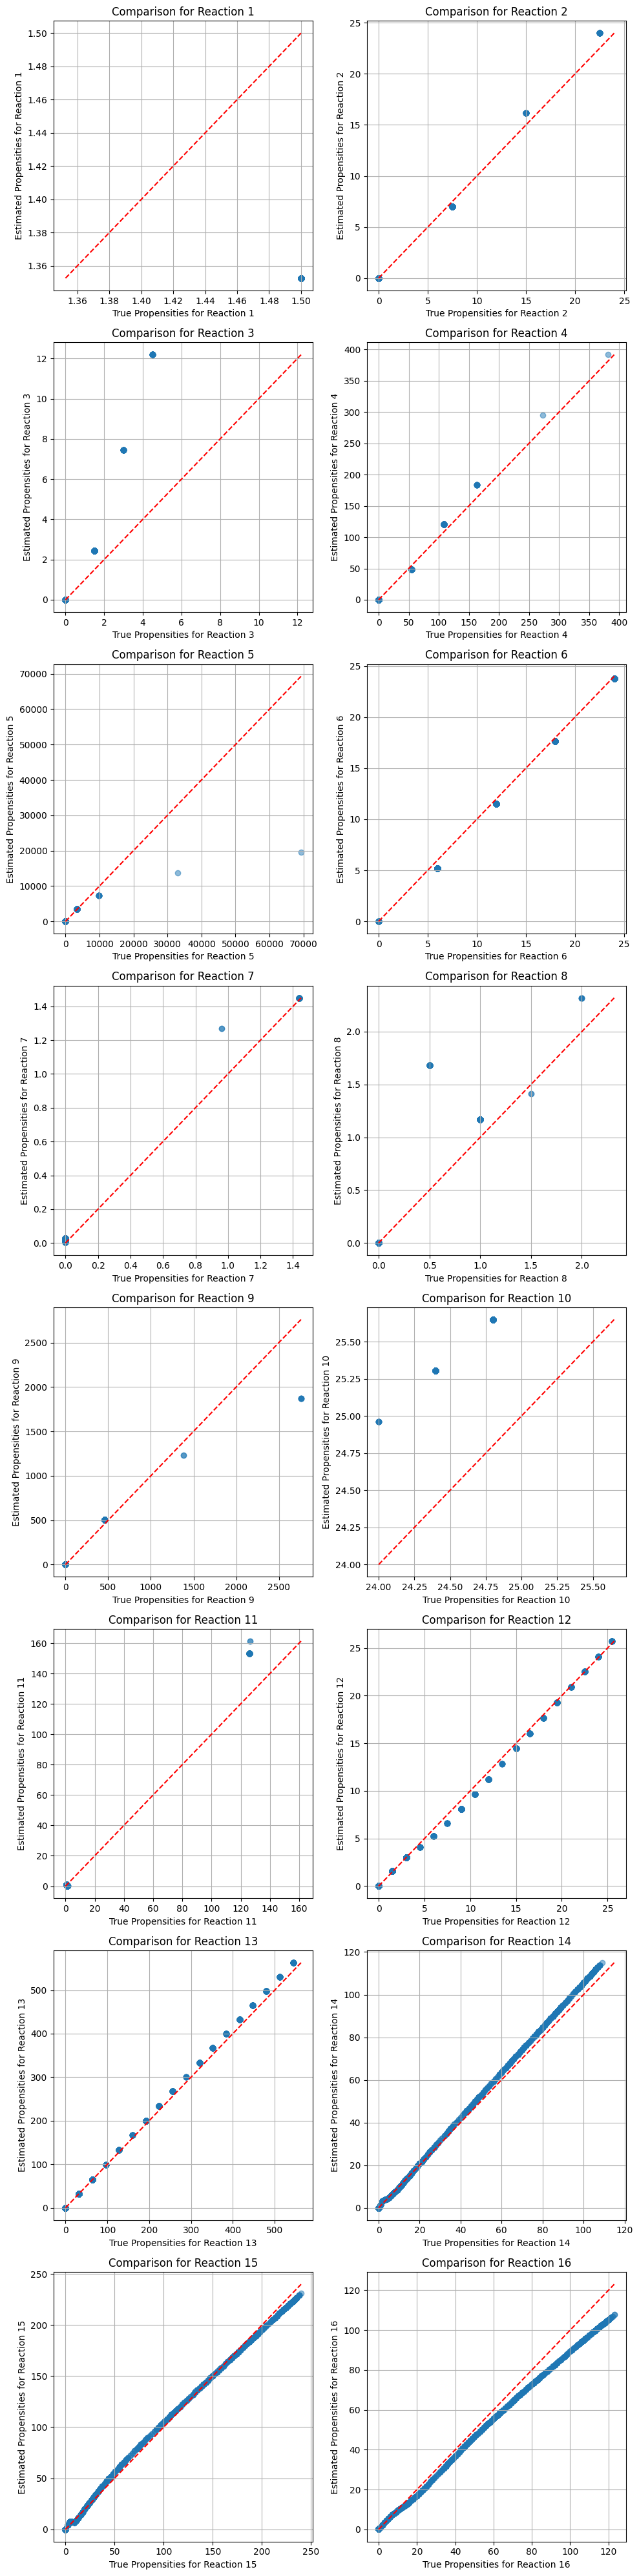

In [46]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lac.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)